In [1]:
import numpy as np
import copy
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
import time

In [2]:
class Room():        
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

In [3]:
class FurnitureItem(): 
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))
        self.sorting = (self.polygon, self.polygon.area)

In [4]:
class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [5]:
problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

In [6]:
def plot(poly):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.show()

In [7]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

In [8]:
shapeFuck = Polygon([(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194),(-1.520878428822382, 0.05762291911687356)])
new_room = problems[10].room.polygon.difference(shapeFuck)

In [29]:
solution = []
room_2 = problems[10].room.polygon
shapes = copy.copy(problems[10].furniture)
initial_area = room_2.area
room_2 = new_room
while (room_2.area) > initial_area*0.7:
    while(room_2.area > 76):
        for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))

    for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4 or len(x)==5:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))
room_2.area

KeyboardInterrupt: 

In [10]:
output = ""
for x in solution:
    output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
print(output)

(-9.74321811986195, -0.9350547282775479), (-10.84568619832866, -3.7695854012394605), (-8.883503743683315, -1.4458298171295578); (-7.401180834291031, -0.4811682971095861), (-6.078018373512965, 2.2573059317974042), (-8.217812343083672, 0.09599110794854315); 


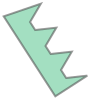

In [11]:
test = Polygon()
for item in problems[10].furniture:
    x, y = item.polygon.exterior.xy
    if(len(x) == 13):
        test = item
        break
test.polygon

In [12]:
import pickle as cPickle
with open("output.pkl", "rb") as input:
    shape13 = cPickle.load(input)


In [13]:
shape13

'(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194); '

In [14]:
shapeFuck = Polygon([(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194),(-1.520878428822382, 0.05762291911687356)])

In [15]:
room_11 = problems[10].room.polygon
furniture_items_13 = []

for item in problems[10].furniture:
    x,y = item.polygon.exterior.xy
    if(len(x)==13):
        furniture_items_13.append(item.polygon)

In [ ]:
%matplotlib inline
import pandas as pd
from IPython import display

roomX,roomY = problems[10].room.polygon.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
z= 0
item = furniture_items_13[3]
print(z)
itemExX,itmeExY = item.exterior.xy
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
for i in range(250,300):
    rotated_trans_shape = affinity.rotate(trans_shape, i, origin=(x, y))
    sX,sY = rotated_trans_shape.exterior.xy  
    plt.plot(roomX, roomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.plot(sX, sY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    display.display(plt.gcf())
    display.display(plt.clf())
    display.clear_output(wait=True)
    time.sleep(0.0001)            
            

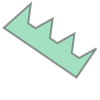

In [17]:
item = furniture_items_13[3]
itemExX,itmeExY = item.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[10]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
rotated_trans_shape = affinity.rotate(trans_shape, 271.6749657167449925054825143888592720031738281250, origin=(x, y))
rotated_trans_shape.difference(room_11)

In [36]:
item = furniture_items_13[3]
itemExX,itmeExY = item.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
rotated_trans_shape = affinity.rotate(trans_shape, 259.5604053764044, origin=(x, y))
a,b = rotated_trans_shape.exterior.xy
print(rotated_trans_shape.difference(room_11).area)
coords = list(zip(*(a,b)))

7.182424167590647e-14


In [37]:
str(coords)

'[(6.5503158452884236e-15, -5.773159728050814e-15), (-1.069337658795283, -0.32636937889791806), (-1.413752942113506, 0.0360918088406148), (-1.0332458499546617, 1.0873835632155942), (-2.1025835087499516, 0.7610141843176814), (-2.4469987920681744, 1.1234753720562152), (-2.0664916999093297, 2.1747671264311945), (-3.13582935870462, 1.8483977475332818), (-3.480244642022843, 2.2108589352718147), (-3.099737549863999, 3.262150689646795), (-4.893997584136356, 2.2469507441124357), (-1.4498447509541268, -1.3776611332728972), (6.5503158452884236e-15, -5.773159728050814e-15)]'

In [35]:
import tensorflow as tf

x = tf.Variable(float(10.0), trainable=True)
f_a = float(affinity.rotate(trans_shape, a, origin=(x, y), use_radians=True).difference(room_11).area)

loss = f_a
opt = tf.train.GradientDescentOptimizer(0.1).minimize(f_x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        print(sess.run([a,loss]))
        sess.run(opt)

TypeError: must be real number, not array.array

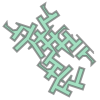

In [54]:
shape1 = Polygon([(-15.08889668642394, 3.9482917599290186), (-15.486653963472579, 4.34108833394011), (-15.409086789277868, 4.578750559561785), (-14.85619516383981, 4.661278436794042), (-15.253952440888451, 5.054075010805132), (-15.176385266693742, 5.291737236426808), (-14.623493641255685, 5.374265113659066), (-15.021250918304325, 5.7670616876701555), (-14.943683744109617, 6.00472391329183), (-14.390792118671559, 6.087251790524089), (-15.263873846963548, 6.635182712924596), (-16.039545588910634, 4.258560456707853)
])
shape2 = Polygon([(-5.6189199596134385, 1.558120177475971), (-5.782104649062396, 2.092789006873615), (-5.60087405519313, 2.2649966485327266), (-5.07522817800564, 2.074743102453306), (-5.238412867454597, 2.609411931850952), (-5.057182273585332, 2.781619573510064), (-4.531536396397843, 2.591366027430643), (-4.6947210858468, 3.1260348568282867), (-4.513490491977533, 3.2982424984873995), (-3.9878446147900437, 3.1079889524079785), (-4.495444587557226, 4.0051189695441565), (-6.307750526249887, 2.2830425529530354)
])
shape3 = Polygon([(6.5503158452884236e-15, -5.773159728050814e-15), (-1.069337658795283, -0.32636937889791806), (-1.413752942113506, 0.0360918088406148), (-1.0332458499546617, 1.0873835632155942), (-2.1025835087499516, 0.7610141843176814), (-2.4469987920681744, 1.1234753720562152), (-2.0664916999093297, 2.1747671264311945), (-3.13582935870462, 1.8483977475332818), (-3.480244642022843, 2.2108589352718147), (-3.099737549863999, 3.262150689646795), (-4.893997584136356, 2.2469507441124357), (-1.4498447509541268, -1.3776611332728972)])

multipolygon = room_11.difference(shape1).difference(shape2).difference(shape3)
real_room = multipolygon[0]
real_room

In [ ]:
solution = []
room_2 = problems[10].room.polygon
shapes = copy.copy(problems[10].furniture)
initial_area = room_2.area
room_2 = real_room
while (room_2.area) > initial_area*0.7:
    while(room_2.area > 76):
        for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))

    for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4 or len(x)==5:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))
room_2.area

499 81.00000000000007
498 79.50000000000007
497 78.00000000000007
496 76.50000000000007
495 75.00000000000007
494 74.00000000000007
493 73.00000000000007
492 72.00000000000007
491 71.00000000000007
490 70.00000000000007
489 69.00000000000007
